# MIPD of warfarin

In [14]:
import os

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import myokit
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()

from model import define_wajima_model

## Visualise demographics of trial cohort

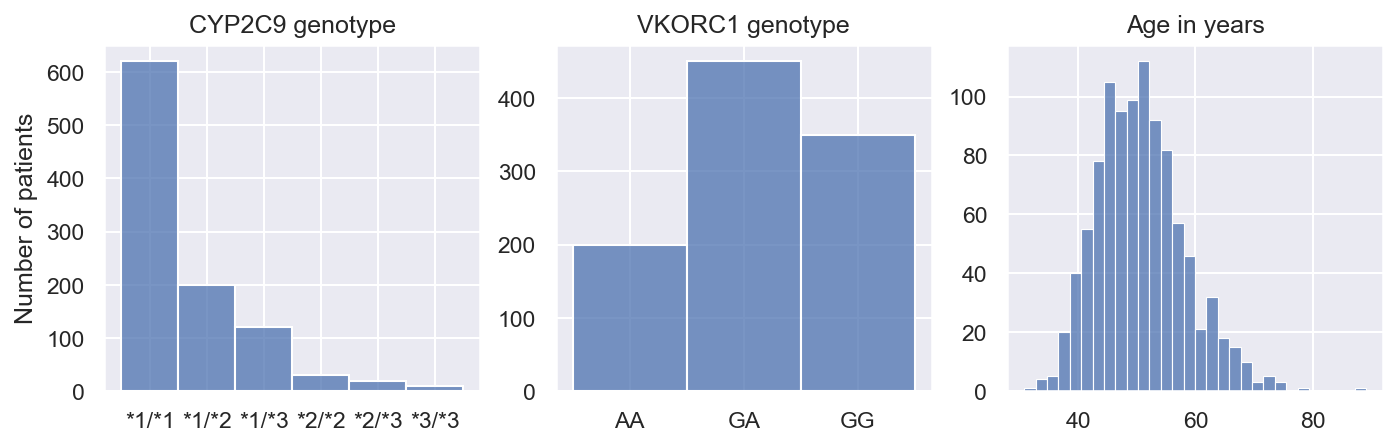

In [11]:
# Import data
directory = os.path.dirname(os.getcwd())
df_demo = pd.read_csv(directory + '/data/mipd_trial_cohort.csv')

# Reshape data
ids = df_demo.ID.dropna().unique()
cyp = []
vkorc = []
age = np.empty(len(ids))
cyp_decoder = {
    0: '*1/*1', 1: '*1/*2', 2: '*1/*3', 3: '*2/*2', 4: '*2/*3', 5: '*3/*3'}
vkorc_decoder = {0: 'GG', 1: 'GA', 2: 'AA'}
for idx, _id in enumerate(ids):
    temp = df_demo[df_demo.ID == _id]
    cyp.append(cyp_decoder[int(temp['CYP2C9'].values)])
    vkorc.append(vkorc_decoder[int(temp['VKORC1'].values)])
    age[idx] = temp['Age'].values
cyp.sort()
vkorc.sort()

# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, hspace=2.5)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot CYP2C9 distribution
sns.histplot(cyp, ax=axes[0])
sns.histplot(vkorc, ax=axes[1])
sns.histplot(age, ax=axes[2])

# Label axes
titles = ['CYP2C9 genotype', 'VKORC1 genotype', 'Age in years']
ylabels = ['Number of patients', '', '']
for ida, ax in enumerate(axes):
    ax.set_title(titles[ida])
    ax.set_ylabel(ylabels[ida])

plt.show()

## Evaluate optimal dosing strategy

This establishes a "best case scenario" where our model captures the
dose response perfectly.

Define routine that rounds dose amount to multiple of commercially available
tablets

In [318]:
def convert_to_tablets(dose):
    """
    Available tablets are:

    - 1 mg
    - 2 mg
    - 2.5 mg
    - 3 mg
    - 4 mg
    - 5 mg
    - 6 mg
    - 7.5 mg
    - 10 mg

    As a result, we define the following conversion:
        1. If dose is < 0.5: 0mg
        2. If dose is >= 0.5 and < 1.5: 1mg
        3. If dose is >= 1.5 and < 2.25: 2mg
        4. If dose is >= 2.25 and < 2.75: 2.5mg
        5. Remaining doses are rounded to next half mg dose.
    """
    if dose < 0.5:
        return 0
    elif dose < 1.5:
        return 1
    elif dose < 2.25:
        return 2
    else:
        return np.round(2 * dose) / 2

Simulate INR response for optimal dosing strategy

In [365]:
# Define model
model, _ = define_wajima_model(patient=True, inr_test=True)

# Get patient parameters
ids = df_demo.ID.dropna().unique()
parameters = np.empty(shape=(len(ids), model.n_parameters()))
for idx, _id in enumerate(ids):
    temp = df_demo[df_demo.ID == _id]
    parameters[idx] = temp[model.parameters()].values[0]

# Load dosing strategy
directory = os.getcwd()
df_doses = pd.read_csv(directory + '/mipd_trial_optimal_dosing_regimens.csv')

# Convert dosing strategy to dosing regimens
days = 19
cal_time = 100 * 24
duration = 0.01
dosing_regimens = {}
doses = np.empty(shape=(len(df_doses.ID.dropna().unique()), days))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    temp = df_doses[df_doses.ID == _id]
    doses[idx] = \
        temp[['Dose %d in mg' % (idx+1) for idx in range(days)]].values[0]
    dose_rates = doses[idx] / duration
    regimen = myokit.Protocol()
    for day, dr in enumerate(dose_rates):
        if dr == 0:
            continue
        regimen.add(myokit.ProtocolEvent(
            level=dr,
            start=cal_time+day*24,
            duration=duration))
    dosing_regimens[int(_id)] = regimen

# Simulate INR response to treatment
times = cal_time + np.arange(days) * 24
# inrs = np.empty(shape=(len(df_doses.ID.dropna().unique()), len(times)))
inrs = np.empty(shape=(221, len(times)))
for idx, _id in enumerate(dosing_regimens.keys()):
    if idx >= 221:
        break
    # Set dosing regimen
    model.set_dosing_regimen(dosing_regimens[_id])

    # Simulate treatment response
    mask = ids == _id
    try:
        inrs[idx] = model.simulate(parameters=parameters[mask][0], times=times)
    except TypeError:
        print(_id)

Visualise treatment response

/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


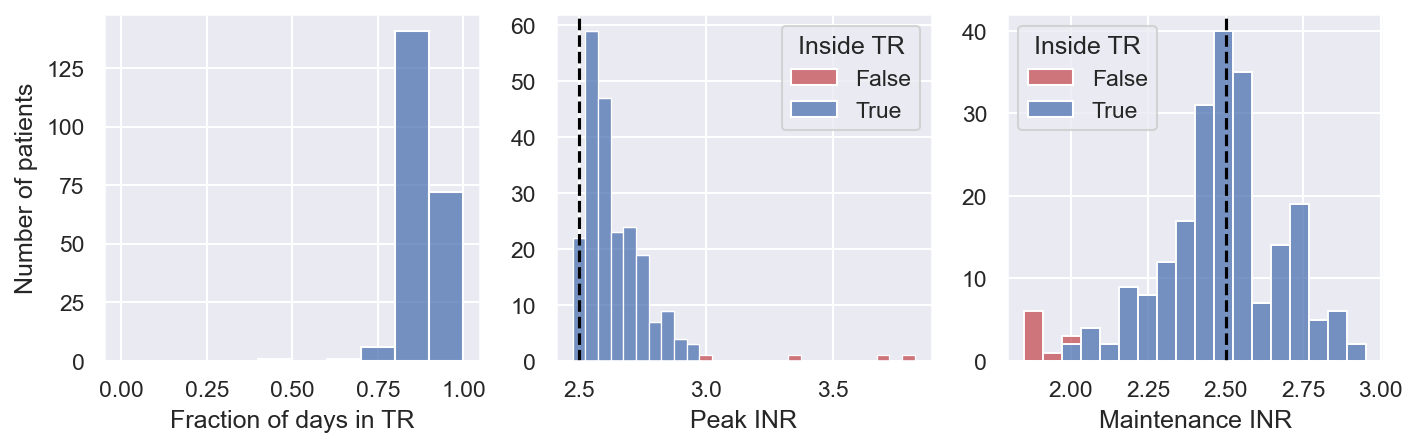

In [368]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, hspace=2.5)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
in_tr = (inrs >= 2) & (inrs <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[0], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot distribution of peak INR
max_inrs = np.max(inrs, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[1], multiple='stack',
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[1].axvline(x=2.5, color='black', linestyle='dashed')

# Plot maintenance INR distirbution
final_inrs = inrs[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[2], multiple='stack',
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[2].axvline(x=2.5, color='black', linestyle='dashed')


# Label axes
axes[0].set_xlabel('Fraction of days in TR')
axes[0].set_ylabel('Number of patients')
axes[0].set_xlim([-0.05, 1.05])
axes[1].set_xlabel('Peak INR')
axes[1].set_ylabel('')
axes[2].set_xlabel('Maintenance INR')
axes[2].set_ylabel('')

plt.show()

Visualise dosing regimens

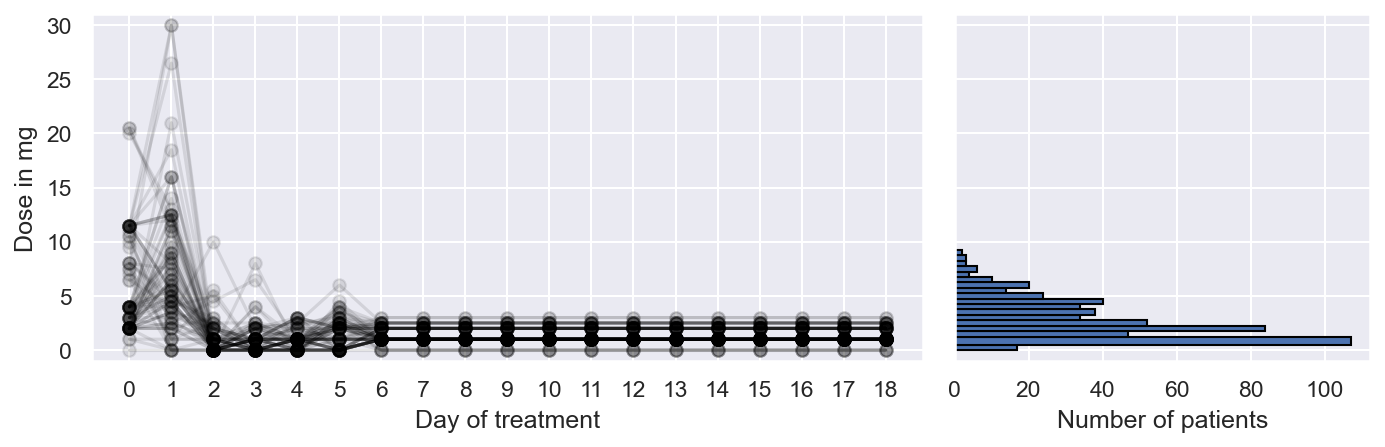

In [340]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[2, 1])

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
maintenance_dose = {}
for d in doses[:80]:
    axes[0].plot(np.arange(days), d, marker='o', color='black', alpha=0.1)
    maintenance_dose[str(d[-1])] = 1
axes[1].hist(
    x=doses[:, -1],
    color=sns.color_palette()[0],
    orientation='horizontal',
    edgecolor='black',
    bins=[
        0, 0.5, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75,
        6.25, 6.75, 7.25, 7.75, 8.25, 8.75, 9.25])

# Label axes
axes[0].set_xlabel('Day of treatment')
axes[0].set_ylabel('Dose in mg')
axes[0].set_ylim([-1, 31])
axes[0].set_xticks(list(range(days)))
axes[1].set_xlabel('Number of patients')
axes[1].set_yticklabels(labels=[], visible=False)
axes[1].set_ylim([-1, 31])
axes[1].set_ylabel('')


plt.show()

## Evaluate linear regression model

Simulate INR response for predicted dosing regimens

In [369]:
# Define model
model, _ = define_wajima_model(patient=True, inr_test=True)

# Get patient parameters
ids = df_demo.ID.dropna().unique()
parameters = np.empty(shape=(len(ids), model.n_parameters()))
for idx, _id in enumerate(ids):
    temp = df_demo[df_demo.ID == _id]
    parameters[idx] = temp[model.parameters()].values[0]

# Load dosing strategy
directory = os.path.dirname(os.getcwd())
df_doses = pd.read_csv(
    directory + '/3_linear_regression_model'
    '/mipd_trial_predicted_dosing_regimens.csv')

# Convert dosing strategy to dosing regimens
# The induction doses are fixed to 10, 5 on days 1 and 2
days = 19
cal_time = 100 * 24
duration = 0.01
dosing_regimens = {}
doses = np.empty(shape=(len(df_doses.ID.dropna().unique()), days))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    temp = df_doses[df_doses.ID == _id]
    doses[idx] = np.array(
        [10, 5]
        + [convert_to_tablets(temp['Maintenance dose'].values[0])] * (days-2))
    dose_rates = doses[idx] / duration
    regimen = myokit.Protocol()
    for day, dr in enumerate(dose_rates):
        regimen.add(myokit.ProtocolEvent(
            level=dr,
            start=cal_time+day*24,
            duration=duration))
    dosing_regimens[int(_id)] = regimen

# Simulate INR response to treatment
times = cal_time + np.arange(days) * 24
inrs = np.empty(shape=(len(df_doses.ID.dropna().unique()), len(times)))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    # Set dosing regimen
    model.set_dosing_regimen(dosing_regimens[int(_id)])

    # Simulate treatment response
    mask = ids == _id
    inrs[idx] = model.simulate(parameters=parameters[mask][0], times=times)

Visualise treatment response

/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


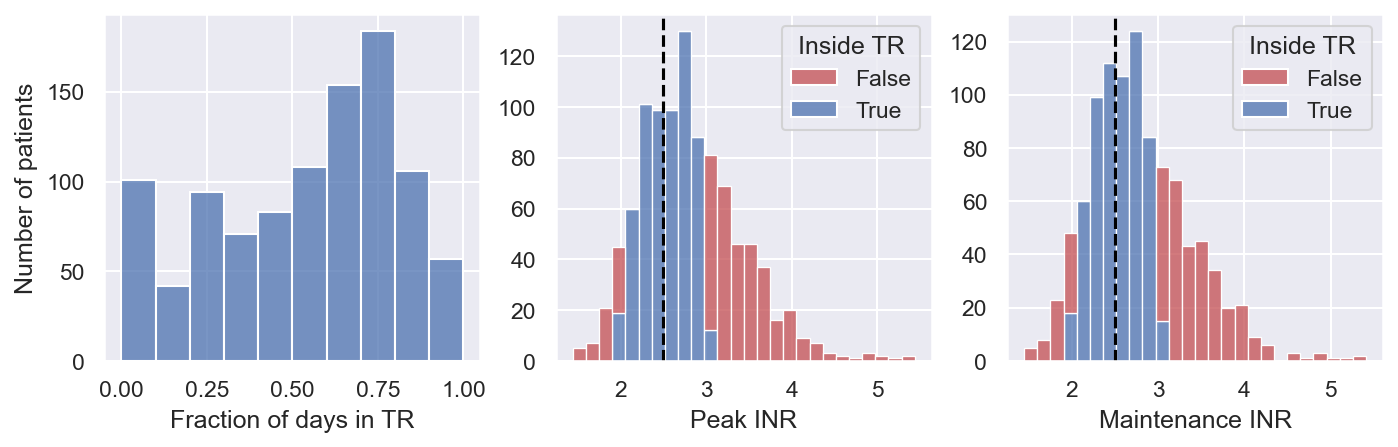

In [370]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, hspace=2.5)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
in_tr = (inrs >= 2) & (inrs <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[0], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot distribution of peak INR
max_inrs = np.max(inrs, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[1], multiple='stack',
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[1].axvline(x=2.5, color='black', linestyle='dashed')

# # Plot maintenance INR distirbution
final_inrs = inrs[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[2], multiple='stack',
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[2].axvline(x=2.5, color='black', linestyle='dashed')


# Label axes
axes[0].set_xlabel('Fraction of days in TR')
axes[0].set_ylabel('Number of patients')
axes[0].set_xlim([-0.05, 1.05])
axes[1].set_xlabel('Peak INR')
axes[1].set_ylabel('')
axes[2].set_xlabel('Maintenance INR')
axes[2].set_ylabel('')

plt.show()

Visualise dosing regimens

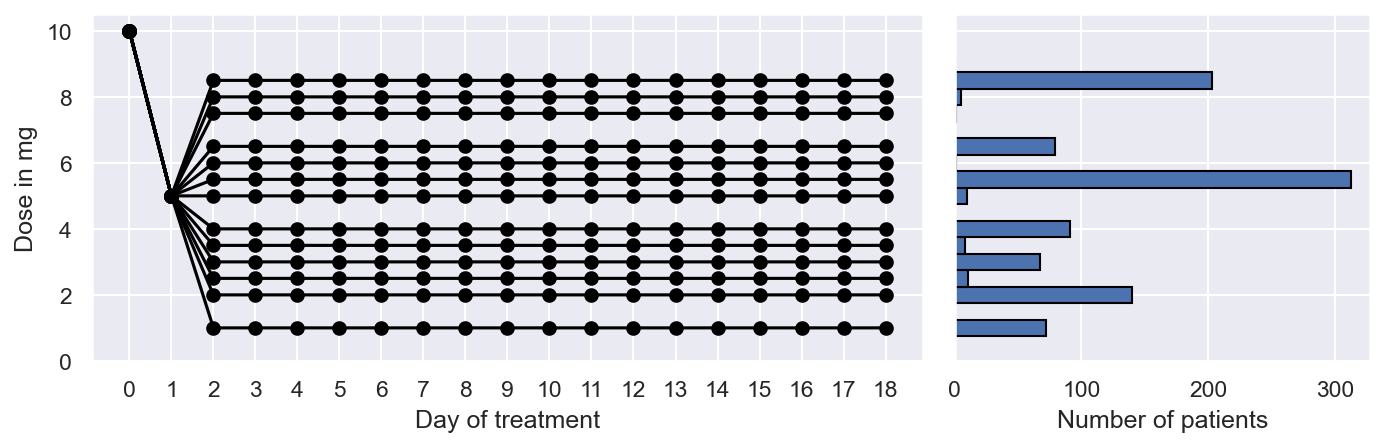

In [300]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[2, 1])

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
maintenance_dose = {}
for d in doses:
    if str(d[-1]) in maintenance_dose.keys():
        maintenance_dose[str(d[-1])] += 1
        continue
    axes[0].plot(np.arange(days), d, marker='o', color='black')
    maintenance_dose[str(d[-1])] = 1
axes[1].hist(
    x=doses[:, -1],
    color=sns.color_palette()[0],
    orientation='horizontal',
    edgecolor='black',
    bins=[
        0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75,
        6.25, 6.75, 7.25, 7.75, 8.25, 8.75, 9.25])

# Label axes
axes[0].set_xlabel('Day of treatment')
axes[0].set_ylabel('Dose in mg')
axes[0].set_ylim([0, 10.5])
axes[0].set_xticks(list(range(days)))
axes[1].set_xlabel('Number of patients')
axes[1].set_yticklabels(labels=[], visible=False)
axes[1].set_ylim([0, 10.5])
axes[1].set_ylabel('')


plt.show()

## Evaluate PKPD model (covariates only)

Simulate INR response for predicted dosing regimens

In [381]:
# Define model
model, _ = define_wajima_model(patient=True, inr_test=True)

# Get patient parameters
ids = df_demo.ID.dropna().unique()
parameters = np.empty(shape=(len(ids), model.n_parameters()))
for idx, _id in enumerate(ids):
    temp = df_demo[df_demo.ID == _id]
    parameters[idx] = temp[model.parameters()].values[0]

# Load dosing strategy
directory = os.path.dirname(os.getcwd())
df_doses = pd.read_csv(
    directory + '/2_semi_mechanistic_model'
    '/mipd_trial_predicted_dosing_regimens.csv')
df_doses = df_doses[df_doses['Number of observations'] == 0]

days = 19
cal_time = 100 * 24
duration = 0.01
dosing_regimens = {}
doses = np.empty(shape=(len(df_doses.ID.dropna().unique()), days))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    temp = df_doses[df_doses.ID == _id]
    doses[idx] = \
        temp[['Dose %d in mg' % (idx+1) for idx in range(days)]].values[0]
    dose_rates = doses[idx] / duration
    regimen = myokit.Protocol()
    for day, dr in enumerate(dose_rates):
        regimen.add(myokit.ProtocolEvent(
            level=dr,
            start=cal_time+day*24,
            duration=duration))
    dosing_regimens[int(_id)] = regimen

# Simulate INR response to treatment
times = cal_time + np.arange(days) * 24
inrs = np.empty(shape=(len(df_doses.ID.dropna().unique()), len(times)))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    # Set dosing regimen
    model.set_dosing_regimen(dosing_regimens[int(_id)])

    # Simulate treatment response
    mask = ids == _id
    unstable = True
    counter = 0
    change = -0.5
    while unstable:
        try:
            inrs[idx] = model.simulate(
                parameters=parameters[mask][0], times=times)
            unstable = False
        except TypeError:
            if doses[idx, counter % 5] <= 0:
                change = 0.5
            if doses[idx, counter % 5] < 2:
                doses[idx, counter % 5] += 2 * 0.5
            else:
                doses[idx, counter % 5] += 0.5

            regimen = model.dosing_regimen()
            regimen.events()[0]._level = doses[idx, 0] / duration
            model.set_dosing_regimen(regimen)
            counter += 1
            if counter >= 40:
                print('Not successful after 40 iterations: ', _id)
                break

Visualise treatment response

/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


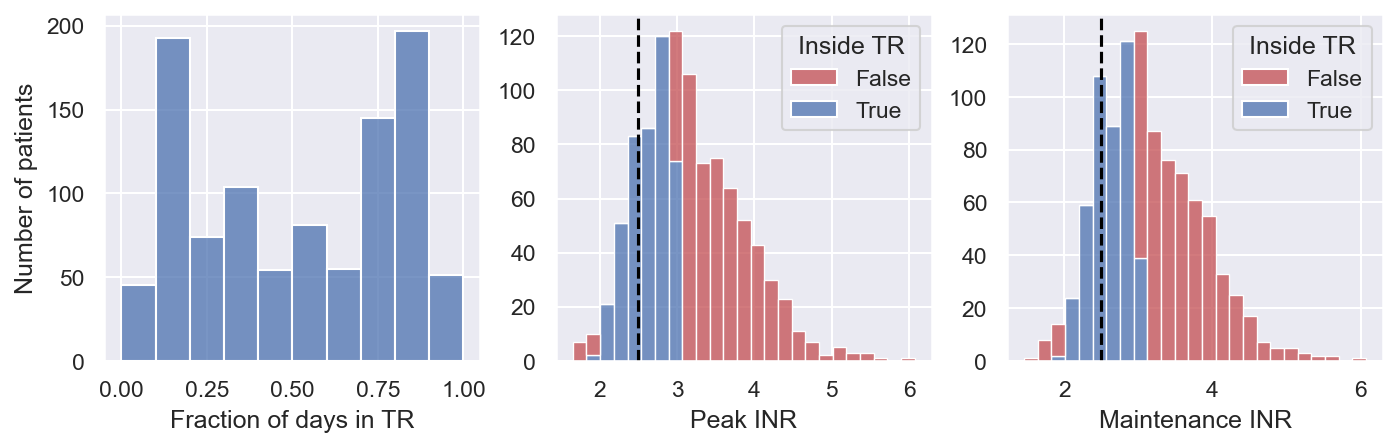

In [382]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, hspace=2.5)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
in_tr = (inrs >= 2) & (inrs <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[0], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot distribution of peak INR
max_inrs = np.max(inrs, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[1], multiple='stack',
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[1].axvline(x=2.5, color='black', linestyle='dashed')

# # Plot maintenance INR distirbution
final_inrs = inrs[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[2], multiple='stack',
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[2].axvline(x=2.5, color='black', linestyle='dashed')


# Label axes
axes[0].set_xlabel('Fraction of days in TR')
axes[0].set_ylabel('Number of patients')
axes[0].set_xlim([-0.05, 1.05])
axes[1].set_xlabel('Peak INR')
axes[1].set_ylabel('')
axes[2].set_xlabel('Maintenance INR')
axes[2].set_ylabel('')

plt.show()

Visualise dosing regimens

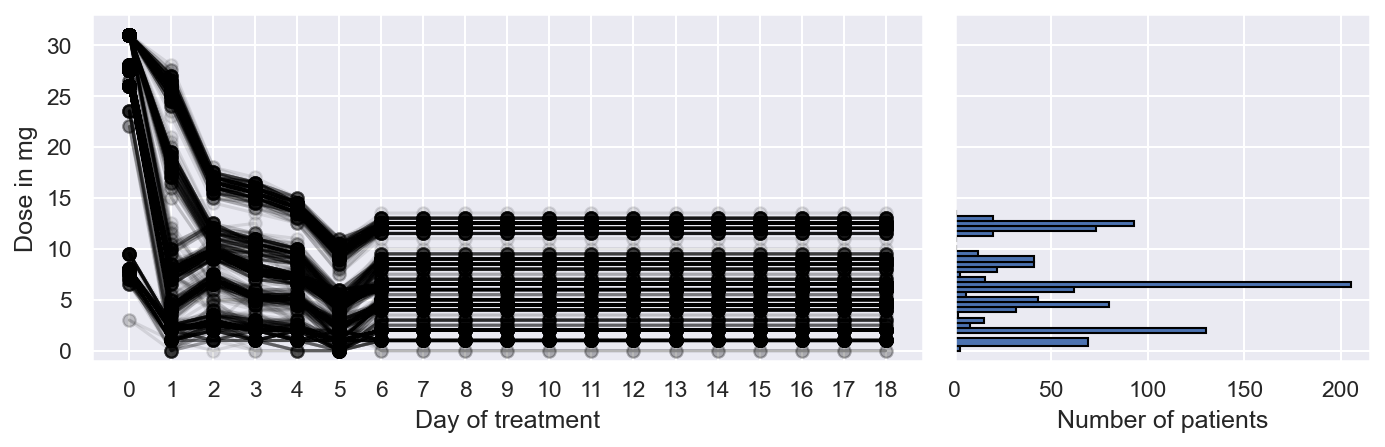

In [384]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[2, 1])

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
maintenance_dose = {}
for d in doses:
    axes[0].plot(np.arange(days), d, marker='o', color='black', alpha=0.1)
    maintenance_dose[str(d[-1])] = 1
axes[1].hist(
    x=doses[:, -1],
    color=sns.color_palette()[0],
    orientation='horizontal',
    edgecolor='black',
    bins=[
        0, 0.5, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75,
        6.25, 6.75, 7.25, 7.75, 8.25, 8.75, 9.25, 9.75, 10.25, 10.75, 11.25,
        11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75, 15.25, 15.75])

# Label axes
axes[0].set_xlabel('Day of treatment')
axes[0].set_ylabel('Dose in mg')
axes[0].set_ylim([-1, 33])
axes[0].set_xticks(list(range(days)))
axes[1].set_xlabel('Number of patients')
axes[1].set_yticklabels(labels=[], visible=False)
axes[1].set_ylim([-1, 33])
axes[1].set_ylabel('')


plt.show()